Make sure to set all parameters in this top cell. Included in the repository are the Biagi, Puech, and BSR databases. All have a minimum indexing eV of 0.001. Biagi has a maximum indexing eV of 950, BSR has a maximum indexing eV of 300, and Puech has a maximum indexing eV of 150.

In [1]:
import numpy as np
import scipy.interpolate as interpolate
import math
import re
import glob
from matplotlib import pyplot as plt
import os
import matplotlib.pylab as pylab

database = 'BSR' # Will use the cross-sections contained in cross-sections/{database}
eV_min = 1e-3      # The minimum eV addressable using this dataset
eV_max = 2e2     # The maximum eV addressable using this dataset
eV_steps = 1000    # The number of steps to break each cross-section LUT into

The below cell imports the necessary files and creates the functions used to modify the GAr momentum-transfer cross-section.

In [8]:
m_e = 9.1e-31

def E_to_v(eV):
    return np.sqrt((2 * eV * 1.60218e-19) / (m_e))

# Low eV energy-independent LAr cross-sections that merge with the (single) momentum-transfer GAr cross-section at several eV (see Wojcik and Tachiya)
def liquid_sigma_e(eV, gas_sigma_p):
    if eV < 3.85:
        return 5.5e-16
    return gas_sigma_p(eV)

def liquid_sigma_p(eV, S, gas_sigma_p):
    if eV < 4.6:
        return S(eV) * 5.5e-16
    return gas_sigma_p(eV)

eV_list = np.logspace(np.log10(eV_min), np.log10(eV_max), eV_steps)

sigma_p_eVs, sigma_p = np.loadtxt(f'cross-sections/{database}/momentum_xsec.txt', unpack=True)  # m^2
sigma_p *= 1e4                                                                                  # to cm^2
print(sigma_p)
sigma_p_func = interpolate.interp1d(sigma_p_eVs, sigma_p, kind='slinear', fill_value=(0., 0.), bounds_error=False)

sigma_i_eVs, sigma_i = np.loadtxt(f'cross-sections/{database}/ionization_xsec.txt', unpack=True) # m^2
sigma_i *= 1e4                                                                                   # to cm^2  
sigma_i_func = interpolate.interp1d(sigma_i_eVs, sigma_i, kind='slinear', fill_value=(0., 0.), bounds_error=False)

# S is the structure factor of LAr (see Wojcik and Tachiya)
S_eVs = np.array([0, 1, 2, 3, 4, 5, 6, 7])
S = np.array([0.048, 0.055, 0.125, 0.4, 1.115, 1.29, 1.16, 1.01])
S_func = interpolate.interp1d(S_eVs, S, kind='quadratic', fill_value=(0.048, 1), bounds_error=False)

final_sigma_e = np.vectorize(lambda eV: liquid_sigma_e(eV, sigma_p_func))
final_sigma_p = np.vectorize(lambda eV: liquid_sigma_p(eV, S_func, sigma_p_func))

file_list = []
#avgs = np.full(4, 0.)
avgs = np.full(4, 0.)

#for ex_level in [11, 13, 14, 15]:
for ex_level in [11,13,14]:
    file_list.append(glob.glob(f'cross-sections/{database}/{ex_level}/excite_xsec_*.txt'))

#sigma_ex = np.full((4, eV_steps), 0.)
sigma_ex = np.full((3, eV_steps), 0.)
sigma_ex_tot = np.zeros(eV_steps)

for k, file_group in enumerate(file_list):
    for file in file_group:
        x_temp, y_temp = np.loadtxt(file, unpack=True)
        interp_func = interpolate.interp1d(x_temp, y_temp, kind='slinear', fill_value=(0., 0.), bounds_error=False)
        avgs[k] += float(re.search(r'\d*\.\d*', file)[0])
        sigma_ex[k] += interp_func(eV_list) * 1e4
        sigma_ex_tot += interp_func(eV_list) * 1e4
    avgs[k] /= len(file_group)
print(sigma_ex)

[7.3872e-16 6.3401e-16 5.8297e-16 5.5034e-16 4.8352e-16 4.4142e-16
 4.0406e-16 3.6986e-16 3.4359e-16 3.2304e-16 3.0234e-16 2.7330e-16
 1.4537e-16 8.1583e-17 4.6257e-17 2.6212e-17 1.5220e-17 9.9301e-18
 8.3816e-18 9.3388e-18 1.2000e-17 1.5824e-17 2.0441e-17 2.5592e-17
 3.1093e-17 3.6811e-17 4.2653e-17 4.8550e-17 5.4454e-17 6.0329e-17
 6.6151e-17 8.0383e-17 9.4069e-17 1.0719e-16 1.1980e-16 1.3194e-16
 1.4368e-16 1.5509e-16 1.6623e-16 1.7715e-16 1.8790e-16 1.9852e-16
 2.0904e-16 2.1949e-16 2.2990e-16 2.4029e-16 2.5067e-16 2.6105e-16
 2.7146e-16 2.8189e-16 2.9236e-16 3.1342e-16 3.2879e-16 3.4719e-16
 3.6590e-16 3.8500e-16 4.0446e-16 4.2434e-16 4.4459e-16 4.6525e-16
 4.8623e-16 5.0760e-16 5.2932e-16 5.5141e-16 5.7386e-16 5.9667e-16
 6.1984e-16 6.4333e-16 6.6716e-16 6.9129e-16 7.1571e-16 7.4036e-16
 7.6527e-16 7.9039e-16 8.1572e-16 8.4121e-16 8.6686e-16 8.9266e-16
 9.1858e-16 9.4459e-16 9.7064e-16 9.9674e-16 1.0228e-15 1.0489e-15
 1.0749e-15 1.1007e-15 1.1264e-15 1.1519e-15 1.1772e-15 1.2023

The below cell condenses the given excitation cross-sections into four energy bands.

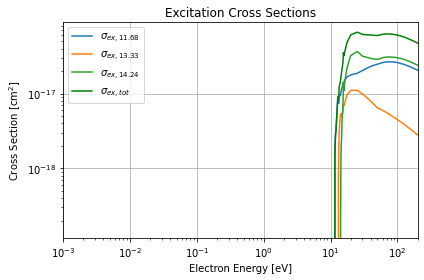

In [5]:
for k, ex_level in enumerate(sigma_ex):
    plt.plot(eV_list, ex_level, label=f'$\sigma_{{ex,{avgs[k]:.2f}}}$')

plt.plot(eV_list, sigma_ex_tot, 'g', label='$\sigma_{ex,tot}$')

plt.xlim(eV_min, eV_max)

plt.xlabel('Electron Energy [eV]')
plt.ylabel('Cross Section [cm$^2$]')

plt.title('Excitation Cross Sections')

plt.xscale('log')
plt.yscale('log')

plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

The cell below show all cross-sections together.

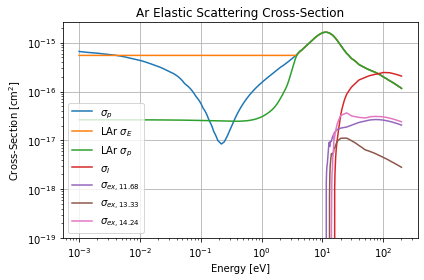

In [6]:
plt.plot(eV_list, sigma_p_func(eV_list), label=r'$\sigma_p$')
plt.plot(eV_list, final_sigma_e(eV_list), label=r'LAr $\sigma_E$')
plt.plot(eV_list, final_sigma_p(eV_list), label=r'LAr $\sigma_p$')

plt.plot(eV_list, sigma_i_func(eV_list), label=r'$\sigma_I$')

for k, ex_level in enumerate(sigma_ex):
    plt.plot(eV_list, ex_level, label=f'$\sigma_{{ex,{avgs[k]:.2f}}}$')

plt.xlabel('Energy [eV]')
plt.ylabel(r'Cross-Section [cm$^2$]')

plt.title('Ar Elastic Scattering Cross-Section')

plt.xscale('log')
plt.yscale('log')

plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

The below cell calculates and shows each cross-section multiplied by the electron velocity corresponding to the $x$-axis kinetic energy. These values are used to calculate the probability of scattering events. $K_\mathrm{max}$ is taken to be the peak of the sum of these values.

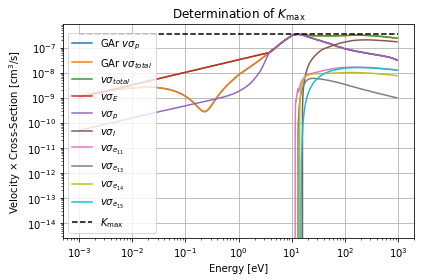

In [5]:
compos_x_sec = np.array([])
for i, e in enumerate(eV_list):
    compos_x_sec = np.append(compos_x_sec, max(final_sigma_e(e), final_sigma_p(e) + sigma_i_func(e) + sigma_ex_tot[i]))

plt.plot(eV_list, sigma_p_func(eV_list) * E_to_v(eV_list) * 1e2, label=r'GAr $v\sigma_p$')
plt.plot(eV_list, (sigma_p_func(eV_list) + sigma_i_func(eV_list) + sigma_ex_tot) * E_to_v(eV_list) * 1e2, label=r'GAr $v\sigma_{total}$')

plt.plot(eV_list, compos_x_sec * E_to_v(eV_list) * 1e2, label=r'$v\sigma_{total}$')

plt.plot(eV_list, final_sigma_e(eV_list) * E_to_v(eV_list) * 1e2, label=r'$v\sigma_E$')
plt.plot(eV_list, final_sigma_p(eV_list) * E_to_v(eV_list) * 1e2, label=r'$v\sigma_p$')

plt.plot(eV_list, sigma_i_func(eV_list) * E_to_v(eV_list) * 1e2, label=r'$v\sigma_I$')
plt.plot(eV_list, sigma_ex[0] * E_to_v(eV_list) * 1e2, label=r'$v\sigma_{e_{11}}$')
plt.plot(eV_list, sigma_ex[1] * E_to_v(eV_list) * 1e2, label=r'$v\sigma_{e_{13}}$')
plt.plot(eV_list, sigma_ex[2] * E_to_v(eV_list) * 1e2, label=r'$v\sigma_{e_{14}}$')
plt.plot(eV_list, sigma_ex[3] * E_to_v(eV_list) * 1e2, label=r'$v\sigma_{e_{15}}$')

plt.xlabel('Energy [eV]')
plt.ylabel(r'Velocity $\times$ Cross-Section [cm$^3$/s]')

K_max = round(np.amax(compos_x_sec * E_to_v(eV_list) * 1e2) * 1.01, 9)
plt.plot(np.logspace(-3, 3, 10), np.full(10, K_max), 'k--', label='$K_{\mathrm{max}}$')
plt.title(f'Determination of $K_{{\mathrm{{max}}}}$')

plt.xscale('log')
plt.yscale('log')

plt.legend(loc=3)
plt.grid()
plt.tight_layout()
plt.show()

This final cell generates the LUTs used by the simulation.

In [12]:
if os.path.exists("../../src/LUTs/CrossSections.h"):
    os.remove("../../src/LUTs/CrossSections.h")

header = open("../../src/LUTs/CrossSections.h", "a+")

np.savetxt(header, [], comments="", header=f"#ifndef CROSSSECTIONS_H\n#define CROSSSECTIONS_H\n\nconst double eV_min = {eV_min};\nconst double eV_max = {eV_max};\nconst int eV_steps = {eV_steps};\n\nconst double K_max = {K_max};\n\nconst double effective_xsec_liquid[] = {{")
np.savetxt(header, final_sigma_e(eV_list), newline=",")
np.savetxt(header, [], comments="", header="\n};\n\nconst double momentum_xsec_liquid[] = {")
np.savetxt(header, final_sigma_p(eV_list), newline=",")
np.savetxt(header, [], comments="", header="\n};\n\nconst double momentum_xsec_gas[] = {")
np.savetxt(header, sigma_p_func(eV_list), newline=",")
np.savetxt(header, [], comments="", header="\n};\n\nconst double excite_xsec_11[] = {")
np.savetxt(header, sigma_ex[0], newline=",")
np.savetxt(header, [], comments="", header="\n};\n\nconst double excite_xsec_13[] = {")
np.savetxt(header, sigma_ex[1], newline=",")
np.savetxt(header, [], comments="", header="\n};\n\nconst double excite_xsec_14[] = {")
np.savetxt(header, sigma_ex[2], newline=",")
np.savetxt(header, [], comments="", header="\n};\n\nconst double excite_xsec_15[] = {")
np.savetxt(header, sigma_ex[3], newline=",")
np.savetxt(header, [], comments="", header="\n};\n\nconst double ionization_xsec[] = {")
np.savetxt(header, sigma_i_func(eV_list), newline=",")
np.savetxt(header, [], comments="", header="\n};\n\n#endif")

header.close()